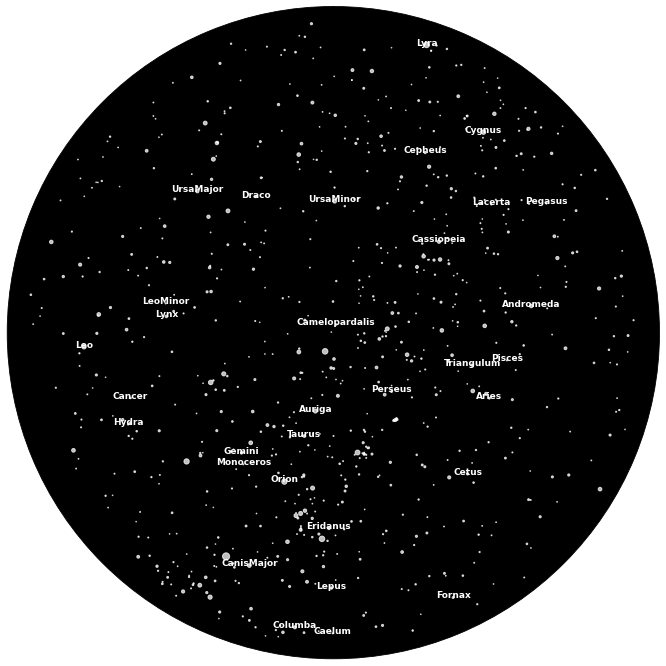

In [66]:
# A version of the star map that plots the stars using a polar plot and azimuth and altitude.
# Stopped after plotting the stars, as the polar plot made any other manipulation or calculations far harder than the XY
# Scatter graph script.

import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
from astropy import units as u

from skyfield.api import Star, load, wgs84, N, S, W, E
from skyfield.data import hipparcos, mpc, stellarium
# import dsos
from skyfield.projections import build_stereographic_projection
from datetime import datetime
from pytz import timezone

#Changable params
#Date/time
ye = 1959
mo = 5
da = 12
ho = 1
mi = 0
se = 0
#Min star size magnitude, larger number is smaller star. i.e. setting to 3 will filter more stars than 5.
limiting_magnitude = 5
#Location that the sky is above. Takes decimal Lat/Long. 
lat = 33.926145
north_south = S
long = 18.420075
west_east = E

# time `t` we use for everything else.
GMT = timezone('Europe/London')
ts = load.timescale()
t = ts.from_datetime(GMT.localize(datetime(ye, mo, da, ho, mi, se)))
# 180 = South 0 = North
degrees = 0.0


location = wgs84.latlon(lat*north_south, long*west_east, elevation_m=0)
position = location.at(t).from_altaz(alt_degrees=90, az_degrees=degrees)

# An ephemeris from the JPL provides Sun and Earth positions.

eph = load('de421.bsp')
sun = eph['sun']
mars = eph['mars']
earth = eph['earth']


# The Hipparcos mission provides our star catalog.

with load.open(hipparcos.URL) as f:
    stardata = hipparcos.load_dataframe(f)



# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/western_SnT/constellationship.fab')

with load.open(url) as f:
    consdata = stellarium.parse_constellations(f)

url2 = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/western_SnT/star_names.fab')

with load.open(url2) as f2:
    star_names = stellarium.parse_star_names(f2)


def generate_constellation_lines(data, polygon=False):
    edges = [edge for name, edges in data for edge in edges]
    edges_star1 = [star1 for star1, star2 in edges]
    edges_star2 = [star2 for star1, star2 in edges]
    xy1 = stardata[['x', 'y']].loc[edges_star1].values
    xy2 = stardata[['x', 'y']].loc[edges_star2].values

    if polygon:
        return [xy1]
    else:

        # The constellation lines will each begin at the x,y of one star and end
        # at the x,y of another.  We have to "rollaxis" the resulting coordinate
        # array into the shape that matplotlib expects.
        #print(np.rollaxis(np.array([xy1, xy2]), 1))
        return np.rollaxis(np.array([xy1, xy2]), 1)


# We will center the chart on position.

projection = build_stereographic_projection(position)
field_of_view_degrees = 180.0


# Now that we have constructed our projection, compute the x and y
# coordinates that each star will have on the plot.

star_positions = earth.at(t).observe(Star.from_dataframe(stardata))
stardata['x'], stardata['y'] = projection(star_positions)



# Create a True/False mask marking the stars bright enough to be
# included in our plot.  And go ahead and compute how large their
# markers will be on the plot.

bright_stars = stardata[stardata['magnitude'] <= limiting_magnitude]
bright_stars = bright_stars[(bright_stars['x']**2 + bright_stars['y']**2)**0.5 <= 1]
magnitude = bright_stars['magnitude']
marker_size = (0.7 + limiting_magnitude - magnitude) ** 2.0


# get the altitude and azimuth for filtered stars
alts = []
azs = []
for star,row in bright_stars.iterrows():
    alt_temp, az_temp, distance = (earth + location).at(t).observe(Star.from_dataframe(stardata.loc[star])).apparent().altaz()
    alts.append(1 - (alt_temp.to(u.rad)/(u.radian*math.pi*0.5)))
    azs.append(az_temp.to(u.rad)/u.radian) 

bright_stars['alt'], bright_stars['az'] = alts,azs


fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(projection='polar')
c = ax.scatter(bright_stars['az'], bright_stars['alt'], s=marker_size, c='white', alpha=0.75)

# # Draw the constellation lines.
constellations = LineCollection(generate_constellation_lines(consdata),
                                 colors='#00f2', linewidths=1, zorder=-1, alpha=0.5)
# ax.add_collection(constellations)

# #adds star names
# for item in star_names:
#     hip = item[0]
#     name = item[1]
#     if hip in bright_stars.index:
#         bsrow = bright_stars.loc[[hip]]
#         ax.text(bsrow['az'],bsrow['alt'], str(name),c='white',fontsize=9, weight='bold', ha='center', va='top',alpha=0.5)


# #adds hip to each star
# for i, s in bright_stars.iterrows():
#     ax.text(s['az'],s['alt'], str(i),c='white',fontsize=7, weight='bold')

#adds constellation name to first star in cons list
for row in consdata:
    name = row[0]
    hip = row[1][0][0]
    if hip in bright_stars.index:
        bsrow = bright_stars.loc[[hip]]
        ax.text(bsrow['az'],bsrow['alt'], str(name),c='white',fontsize=9, weight='bold', ha='center')
    
    
ax.set_theta_zero_location("N")
ax.set_theta_direction(1)
ax.xaxis.set_visible(False)
ax.set_yticklabels([])
ax.grid(False)
ax.set_facecolor('#000000')
#ax.set_ylim(0, limit)
#print(bright_stars)
